In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [9, 6]

import sys

sys.path.append("incl/")

import ELPH_utils
import ELPH_Dim_Reducer

from RedDimApprox import RedDimApprox

In [2]:
runs = ELPH_utils.load_runs(filename='/home/agluedge/Preprints/ELPH/runs/runs_n_kmax=80.npz')

# runs = runs[:100:1]
# for k in range(len(runs)):
#     runs[k] = runs[k][:,::2]

n_runs = len(runs)
n_kmax = runs[0].shape[0]

print(n_runs, 'loaded with n_kmax =', n_kmax)

1000 loaded with n_kmax = 80


In [3]:
# dim_reducer = ELPH_Dim_Reducer.SVD()
# dim_reducer = ELPH_Dim_Reducer.FFT(sorted=True)
dim_reducer = ELPH_Dim_Reducer.Hermite(sample_max = 1.856, sorted=True, optimize=True, orthogonalize=False, train_rdim=20)

model = RedDimApprox(runs, dim_reducer)
model.train()
print(dim_reducer.sample_max)

print(model.get_error(runs[9], rdim=20, norm='std'))

KeyboardInterrupt: 

In [ ]:
# dim_reducer = ELPH_Dim_Reducer.SVD()
# dim_reducer = ELPH_Dim_Reducer.FFT(sorted=True)
dim_reducer = ELPH_Dim_Reducer.Hermite(sample_max = 1.856, sorted=True, optimize=True, orthogonalize=True, train_rdim=40)

model = RedDimApprox(dim_reducer=dim_reducer)

train_kwargs = {}
score_kwargs = {'norm':'std', 'rdim':40}

m,s = ELPH_utils.get_KFold_CV_scores(model, runs, folds=5, seed=817, train_kwargs=train_kwargs, score_kwargs=score_kwargs)

print(m)
print(s)

In [27]:
norm = 'max'
threshold = 0.01

# n_kmax_ar = [220,230]
# n_kmax_ar = [10,20,30,40,50,60,70,80,90,100,110,120,130,140]
# n_kmax_ar = np.arange(10,235,10)
n_kmax_ar = np.arange(150,235,10)

rdim_buffer = 5
previous_min_rdim = 134 + rdim_buffer
min_rdim_ar = []

for k, n_kmax in enumerate(n_kmax_ar):
    runs = ELPH_utils.load_runs(filename='/home/agluedge/Preprints/ELPH/runs/runs_n_kmax='+str(n_kmax)+'.npz')
    n_runs = len(runs)
    assert n_kmax == runs[0].shape[0]
    
    print(n_runs, 'loaded with n_kmax =', n_kmax)
    
    for rdim in range(previous_min_rdim-rdim_buffer,n_kmax+1):
        
        try:
    #         dim_reducer = ELPH_Dim_Reducer.SVD()
    #         dim_reducer = ELPH_Dim_Reducer.FFT(sorted=True)
            dim_reducer = ELPH_Dim_Reducer.Hermite(sorted=True, optimize=True, orthogonalize=True, train_rdim=rdim)

            model = RedDimApprox(dim_reducer=dim_reducer)

            score_kwargs = {'norm':norm, 'rdim':rdim}
            m,s = ELPH_utils.get_KFold_CV_scores(model, runs, folds=10, seed=817, train_kwargs={}, score_kwargs=score_kwargs)
    #         print('rdim:', rdim, 'mean score', m)
            std = np.std(s)

            score = m+std

            if score < threshold:
                previous_min_rdim = rdim
                min_rdim_ar.append(rdim)
                print('min rdim:', rdim, 'mean + std', score)
                break
        except:
            score = 10.0
            
    if score > threshold:        
        min_rdim_ar.append(rdim)
        print('max rdim reached:', rdim, 'mean score', score)
    

1000 loaded with n_kmax = 150
min rdim: 147 mean + std 0.00950939982258331
1000 loaded with n_kmax = 160
min rdim: 159 mean + std 0.0043487364112259706
1000 loaded with n_kmax = 170
min rdim: 162 mean + std 0.00830978604082256
1000 loaded with n_kmax = 180

Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.
min rdim: 179 mean + std 0.006046447992271515
1000 loaded with n_kmax = 190

Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.
min rdim: 189 mean + std 0.003366848225605212
1000 loaded with n_kmax = 200
min rdim: 197 mean + std 0.005695520182529765
1000 loaded with n_kmax = 210

Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.
min rdim: 206 mean + std 0.008530933033257707
1000 loaded with n_km

(9, 2)
[[150 147]
 [160 159]
 [170 162]
 [180 179]
 [190 189]
 [200 197]
 [210 206]
 [220 215]
 [230 225]]


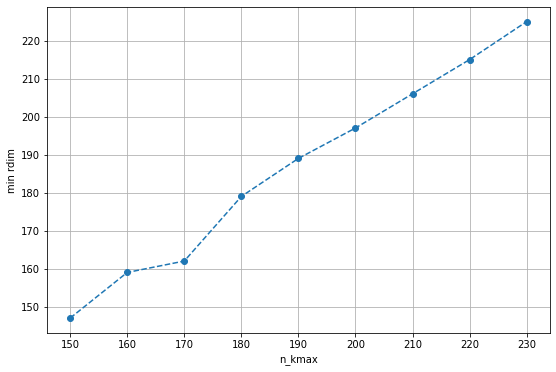

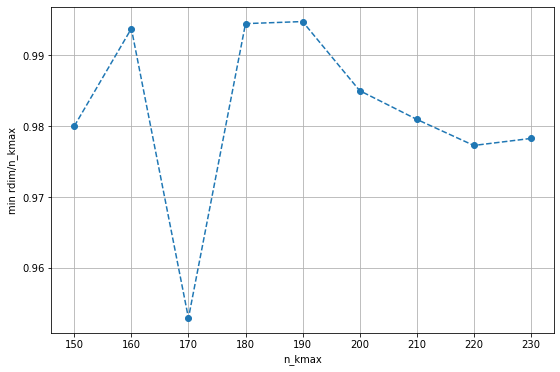

In [30]:
n_kmax_ar = np.asarray(n_kmax_ar)
min_rdim_ar = np.asarray(min_rdim_ar)

data = np.stack((n_kmax_ar[:min_rdim_ar.size],min_rdim_ar),axis=1)

# prev_data = np.loadtxt('/home/agluedge/Preprints/ELPH/figs/red_dim_apprx/hermite_max')
# data = np.concatenate((prev_data,data),axis=0)


print(data.shape)
print(data)

# np.savetxt('/home/agluedge/Preprints/ELPH/figs/red_dim_apprx/hermite_max', data)



plt.grid()
plt.plot(data[:,0],data[:,1], '--', marker='o')
plt.xlabel('n_kmax')
plt.ylabel('min rdim')
plt.show()


plt.grid()
plt.plot(data[:,0],data[:,1]/data[:,0], '--', marker='o')
plt.xlabel('n_kmax')
plt.ylabel('min rdim/n_kmax')
plt.show()